In [1]:
import json
import os
import sys
from copy import deepcopy
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import skimage
import tifffile
import yaml

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
from mushroom.mushroom import Mushroom, DEFAULT_CONFIG
import mushroom.data.he as he
import mushroom.data.multiplex as multiplex
import mushroom.utils as utils
import mushroom.visualization.utils as vis_utils

In [5]:
run_dir = '/data/estorrs/mushroom/data/projects/examples/full_workflow'
mushroom_dir = os.path.join(run_dir, f'mushroom_singleton') # where mushroom results will be saved
Path(mushroom_dir).mkdir(parents=True, exist_ok=True)

## specify inputs

In [11]:
metadata = yaml.safe_load(open(os.path.join(run_dir, 'registered', 'metadata.yaml')))
yaml.safe_dump(metadata, sys.stdout)

resolution: 1.0
sections:
- data:
  - dtype: visium
    filepath: /data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s0_S18-9906-U1_visium.h5ad
  - dtype: he
    filepath: /data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s0_S18-9906-U1_he.tif
  position: 0
  sid: S18-9906-U1
- data:
  - dtype: xenium
    filepath: /data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s1_S18-9906-U2_xenium.h5ad
  position: 5
  sid: S18-9906-U2
- data:
  - dtype: multiplex
    filepath: /data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s2_S18-9906-U3_multiplex.ome.tiff
  position: 10
  sid: S18-9906-U3
- data:
  - dtype: xenium
    filepath: /data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s3_S18-9906-U9_xenium.h5ad
  position: 40
  sid: S18-9906-U9
- data:
  - dtype: multiplex
    filepath: /data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s4_S18-9906-U10_multiplex.ome.tiff
  positi

In [12]:
# grab only one section
metadata['sections'] = metadata['sections'][:1]
metadata

{'resolution': 1.0,
 'sections': [{'data': [{'dtype': 'visium',
     'filepath': '/data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s0_S18-9906-U1_visium.h5ad'},
    {'dtype': 'he',
     'filepath': '/data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s0_S18-9906-U1_he.tif'}],
   'position': 0,
   'sid': 'S18-9906-U1'}],
 'target_sid': 'S18-9906-U2'}

In [13]:
DEFAULT_CONFIG

{'sections': None,
 'dtype_to_chkpt': None,
 'dtype_specific_params': None,
 'sae_kwargs': {'size': 8,
  'patch_size': 1,
  'encoder_dim': 128,
  'codebook_dim': 64,
  'num_clusters': (8, 4, 2),
  'dtype_to_decoder_dims': {'multiplex': (256, 128, 64),
   'he': (256, 128, 10),
   'visium': (256, 512, 2048),
   'xenium': (256, 256, 256),
   'cosmx': (256, 512, 1024),
   'points': (256, 512, 1024)},
  'recon_scaler': 1.0,
  'neigh_scaler': 0.01},
 'trainer_kwargs': {'input_resolution': 1.0,
  'target_resolution': 0.02,
  'pct_expression': 0.05,
  'batch_size': 128,
  'num_workers': 0,
  'devices': 1,
  'accelerator': 'cpu',
  'max_epochs': 1,
  'steps_per_epoch': 1000,
  'lr': 0.0001,
  'out_dir': './outputs',
  'save_every': 1,
  'log_every_n_steps': 10,
  'logger_type': 'tensorboard',
  'logger_project': 'portobello',
  'channel_mapping': {},
  'data_mask': None}}

In [14]:
config = deepcopy(DEFAULT_CONFIG)
config = utils.recursive_update(config, {
    'sections': metadata['sections'],
    'trainer_kwargs': {
        'input_resolution': metadata['resolution'],
        'target_resolution': metadata['resolution'] / 50.,
        'out_dir': os.path.join(mushroom_dir, 'outputs'),
        'accelerator': 'gpu',
        'steps_per_epoch': 500,
    }
})
config

{'sections': [{'data': [{'dtype': 'visium',
     'filepath': '/data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s0_S18-9906-U1_visium.h5ad'},
    {'dtype': 'he',
     'filepath': '/data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s0_S18-9906-U1_he.tif'}],
   'position': 0,
   'sid': 'S18-9906-U1'}],
 'dtype_to_chkpt': None,
 'dtype_specific_params': None,
 'sae_kwargs': {'size': 8,
  'patch_size': 1,
  'encoder_dim': 128,
  'codebook_dim': 64,
  'num_clusters': (8, 4, 2),
  'dtype_to_decoder_dims': {'multiplex': (256, 128, 64),
   'he': (256, 128, 10),
   'visium': (256, 512, 2048),
   'xenium': (256, 256, 256),
   'cosmx': (256, 512, 1024),
   'points': (256, 512, 1024)},
  'recon_scaler': 1.0,
  'neigh_scaler': 0.01},
 'trainer_kwargs': {'input_resolution': 1.0,
  'target_resolution': 0.02,
  'pct_expression': 0.05,
  'batch_size': 128,
  'num_workers': 0,
  'devices': 1,
  'accelerator': 'gpu',
  'max_epochs': 1,
  'steps_per_epoch': 500,
  

In [15]:
# fps = [mapping['filepath'] 
#        for item in config['sections']
#        for mapping in item['data']
#        if 'multiplex' == mapping['dtype']]
# multiplex.get_channel_counts(fps)

In [16]:
config['dtype_specific_params'] = {
    'visium': {
        'trainer_kwargs': {
            'target_resolution': .01 # lower resolution for visium
        }
    }
}
config

{'sections': [{'data': [{'dtype': 'visium',
     'filepath': '/data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s0_S18-9906-U1_visium.h5ad'},
    {'dtype': 'he',
     'filepath': '/data/estorrs/mushroom/data/projects/examples/full_workflow/registered/s0_S18-9906-U1_he.tif'}],
   'position': 0,
   'sid': 'S18-9906-U1'}],
 'dtype_to_chkpt': None,
 'dtype_specific_params': {'visium': {'trainer_kwargs': {'target_resolution': 0.01}}},
 'sae_kwargs': {'size': 8,
  'patch_size': 1,
  'encoder_dim': 128,
  'codebook_dim': 64,
  'num_clusters': (8, 4, 2),
  'dtype_to_decoder_dims': {'multiplex': (256, 128, 64),
   'he': (256, 128, 10),
   'visium': (256, 512, 2048),
   'xenium': (256, 256, 256),
   'cosmx': (256, 512, 1024),
   'points': (256, 512, 1024)},
  'recon_scaler': 1.0,
  'neigh_scaler': 0.01},
 'trainer_kwargs': {'input_resolution': 1.0,
  'target_resolution': 0.02,
  'pct_expression': 0.05,
  'batch_size': 128,
  'num_workers': 0,
  'devices': 1,
  'accelerator':

## train mushroom

In [18]:
mushroom = Mushroom.from_config(config)

INFO:root:loading spore for he
INFO:root:singleton section detected
INFO:root:data mask detected
INFO:root:starting he processing
INFO:root:2 sections detected: ['S18-9906-U1', 'S18-9906-U1_dup']
INFO:root:processing sections
INFO:root:generating image data for section S18-9906-U1
INFO:root:generating image data for section S18-9906-U1_dup
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 2 sections detected: [('S18-9906-U1', 'he'), ('S18-9906-U1_dup', 'he')]
INFO:root:creating data loaders
INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmp5v_32vft
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmp5v_32vft/_remote_module_non_scriptable.py
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:loading spore for visium
INFO:root:singleton sectio

In [19]:
mushroom.section_ids

[('S18-9906-U1', 'visium'), ('S18-9906-U1', 'he')]

In [20]:
mushroom.train()

INFO:root:starting training for he
Missing logger folder: /data/estorrs/mushroom/data/projects/examples/full_workflow/mushroom_singleton/outputs/he_logs/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 5.0 M 
------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.868    Total estimated model params size (MB)
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:root:finished training he, saved chkpt to /data/estorrs/mushroom/data/projects/examples/full_workflow/mushroom_singleton/outputs/he_chkpts/last.ckpt
INFO:root:starting training for visium
Missing logger folder: /data/estorrs/mushroom/data/projects/examples/full_workflow/mushroom_singleton/outputs/visium_logs/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 24.9 M
------------------------------
24.9 M    Trainable params
0         Non-trainable params
24.9 M    Total params
99.591    Total estimated model params size (MB)


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:root:finished training visium, saved chkpt to /data/estorrs/mushroom/data/projects/examples/full_workflow/mushroom_singleton/outputs/visium_chkpts/last.ckpt


In [21]:
mushroom.embed_sections()

INFO:root:embedding he spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

INFO:root:embedding visium spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                                 …

he


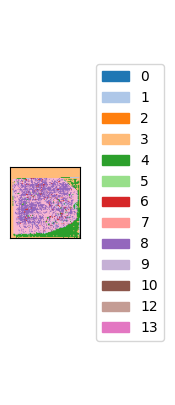

visium


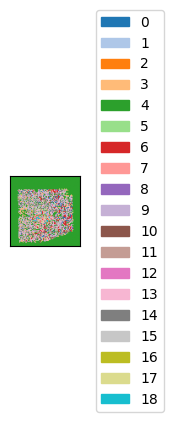

In [22]:
for dtype in mushroom.dtypes:
    print(dtype)
    mushroom.display_clusters(dtype)
    plt.show()

he


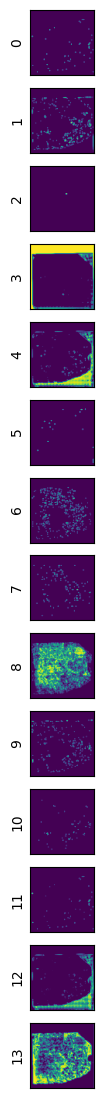

visium


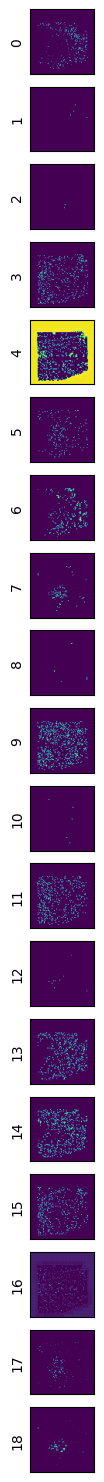

In [24]:
for dtype in mushroom.dtypes:
    print(dtype)
    mushroom.display_cluster_probs(dtype)
    plt.show()

In [25]:
%%time
z_scaler = .1
cluster_res = 1.5
dtype_to_volume = mushroom.generate_interpolated_volumes(z_scaler=z_scaler, level=0, resolution=cluster_res)

INFO:root:generating volume for he spore
INFO:root:generating volume for visium spore
INFO:root:generating integrated volume
INFO:root:merging cluster volumes
INFO:root:constructing graph with 361 edges
INFO:root:53 edges remaining after filtering
INFO:root:19 of 19 nodes processed
INFO:root:starting leiden clustering
INFO:root:finished integration, found 6 clusters


CPU times: user 2.37 s, sys: 284 ms, total: 2.66 s
Wall time: 744 ms


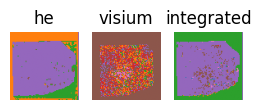

In [29]:
mushroom.display_volumes()

In [31]:
%%time
z_scaler = .1
cluster_res = 2.
dtype_to_volume = mushroom.generate_interpolated_volumes(z_scaler=z_scaler, level=2, resolution=cluster_res)

INFO:root:generating volume for he spore
INFO:root:generating volume for visium spore
INFO:root:generating integrated volume
INFO:root:merging cluster volumes
INFO:root:constructing graph with 3481 edges
INFO:root:929 edges remaining after filtering
INFO:root:59 of 59 nodes processed
INFO:root:starting leiden clustering
INFO:root:finished integration, found 10 clusters


CPU times: user 2.66 s, sys: 130 ms, total: 2.79 s
Wall time: 568 ms


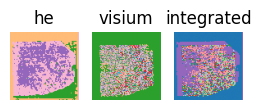

In [33]:
mushroom.display_volumes()

In [34]:
dtype_to_df = mushroom.calculate_cluster_intensities()
dtype_to_df.keys()

dict_keys(['he', 'visium'])

In [36]:
dtype_to_df['visium']

,A2M,A4GALT,AAAS,AACS,AADAT,AAGAB,AAK1,AAMDC,AAMP,AAR2,...,ZSCAN30,ZSWIM7,ZSWIM8,ZSWIM9,ZW10,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,7.004271,3.006504,3.230029,2.592268,2.998890,2.437503,3.573887,3.305854,4.209615,2.273258,...,2.388502,2.530017,3.330882,3.072473,2.558692,3.312335,2.960779,2.984963,5.238177,4.023977
1,7.484167,3.192486,3.532458,2.901481,3.212788,2.554660,3.759032,3.569189,4.725988,2.574652,...,2.497990,2.624689,3.682376,3.212043,2.532831,3.663624,3.291639,3.163563,5.712067,4.418473
2,8.765224,3.720095,4.202307,3.526161,3.786164,3.046826,4.351360,4.171179,5.586217,3.212575,...,3.025259,2.979867,4.479517,3.750580,2.763719,4.476986,3.959545,3.740577,6.712300,5.237610
3,0.393887,0.172171,0.093067,0.089944,0.144587,0.133802,0.128253,0.165998,0.158704,0.084098,...,0.083419,0.178667,0.168825,0.146314,0.140336,0.157742,0.103311,0.047839,0.337547,0.100846
4,-1.007248,-0.477133,-0.512572,-0.373039,-0.484763,-0.365021,-0.627168,-0.487733,-0.770313,-0.380869,...,-0.417261,-0.276549,-0.505059,-0.373921,-0.355862,-0.545144,-0.463966,-0.486625,-0.720072,-0.719589
5,7.137383,3.056975,3.320950,2.680993,3.025722,2.439691,3.646480,3.365247,4.375366,2.354503,...,2.404474,2.568162,3.390780,3.105912,2.547566,3.388785,3.056699,3.018861,5.399109,4.154019
6,9.085892,3.856387,4.365269,3.653298,3.864142,3.137968,4.562552,4.297328,5.786417,3.326723,...,3.149350,3.126402,4.576102,3.906565,2.865614,4.623845,4.105443,3.878691,6.991364,5.455637
7,10.455834,4.332332,5.134535,4.125888,3.203670,2.777053,5.090086,4.559026,6.622301,3.510750,...,2.635386,3.623965,4.149005,3.735855,3.598922,4.297734,4.423665,3.204283,8.788755,7.074135
8,15.908802,6.867924,8.381972,6.661498,4.608819,3.276592,8.213692,6.494484,10.379201,4.915562,...,3.736785,5.907742,5.357302,5.686288,5.623807,5.973647,6.636078,3.566733,14.198792,11.080841
9,2.951543,1.203263,1.217886,0.989651,1.241115,0.977183,1.435238,1.403106,1.730450,0.985521,...,1.014251,1.042686,1.393092,1.244950,1.109081,1.404111,1.169954,1.257618,2.288077,1.560525


In [37]:
dtype_to_df = mushroom.calculate_cluster_intensities(projection_dtype='visium')
dtype_to_df.keys()

dict_keys(['he', 'visium'])

In [38]:
dtype_to_df['visium']

,A2M,A4GALT,AAAS,AACS,AADAT,AAGAB,AAK1,AAMDC,AAMP,AAR2,...,ZSCAN30,ZSWIM7,ZSWIM8,ZSWIM9,ZW10,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,7.004271,3.006504,3.230029,2.592268,2.998890,2.437503,3.573887,3.305854,4.209615,2.273258,...,2.388502,2.530017,3.330882,3.072473,2.558692,3.312335,2.960779,2.984963,5.238177,4.023977
1,7.484167,3.192486,3.532458,2.901481,3.212788,2.554660,3.759032,3.569189,4.725988,2.574652,...,2.497990,2.624689,3.682376,3.212043,2.532831,3.663624,3.291639,3.163563,5.712067,4.418473
2,8.765224,3.720095,4.202307,3.526161,3.786164,3.046826,4.351360,4.171179,5.586217,3.212575,...,3.025259,2.979867,4.479517,3.750580,2.763719,4.476986,3.959545,3.740577,6.712300,5.237610
3,0.393887,0.172171,0.093067,0.089944,0.144587,0.133802,0.128253,0.165998,0.158704,0.084098,...,0.083419,0.178667,0.168825,0.146314,0.140336,0.157742,0.103311,0.047839,0.337547,0.100846
4,-1.007248,-0.477133,-0.512572,-0.373039,-0.484763,-0.365021,-0.627168,-0.487733,-0.770313,-0.380869,...,-0.417261,-0.276549,-0.505059,-0.373921,-0.355862,-0.545144,-0.463966,-0.486625,-0.720072,-0.719589
5,7.137383,3.056975,3.320950,2.680993,3.025722,2.439691,3.646480,3.365247,4.375366,2.354503,...,2.404474,2.568162,3.390780,3.105912,2.547566,3.388785,3.056699,3.018861,5.399109,4.154019
6,9.085892,3.856387,4.365269,3.653298,3.864142,3.137968,4.562552,4.297328,5.786417,3.326723,...,3.149350,3.126402,4.576102,3.906565,2.865614,4.623845,4.105443,3.878691,6.991364,5.455637
7,10.455834,4.332332,5.134535,4.125888,3.203670,2.777053,5.090086,4.559026,6.622301,3.510750,...,2.635386,3.623965,4.149005,3.735855,3.598922,4.297734,4.423665,3.204283,8.788755,7.074135
8,15.908802,6.867924,8.381972,6.661498,4.608819,3.276592,8.213692,6.494484,10.379201,4.915562,...,3.736785,5.907742,5.357302,5.686288,5.623807,5.973647,6.636078,3.566733,14.198792,11.080841
9,2.951543,1.203263,1.217886,0.989651,1.241115,0.977183,1.435238,1.403106,1.730450,0.985521,...,1.014251,1.042686,1.393092,1.244950,1.109081,1.404111,1.169954,1.257618,2.288077,1.560525


In [39]:
out_dir = os.path.join(mushroom_dir, 'outputs')
prefix = os.path.join(out_dir, f'clusters')
for dtype in mushroom.dtype_to_volume.keys():
    for i in range(3):
        root = prefix + f'_{dtype}_axis{i}'
        is_probs = False
        volume = mushroom.dtype_to_volume[dtype]
        vis_utils.volume_to_gif(volume, is_probs, root + '_section.gif', axis=i)
        
        if i in [1, 2]:
            rgb = vis_utils.display_labeled_as_rgb(volume[0], preserve_indices=True)
            vis_utils.save_reference_gif(rgb, root + '_ref.gif', axis=i-1)

In [46]:
mushroom.section_positions

array([0, 0])

In [57]:
mushroom.save()

INFO:root:saving config and outputs to /data/estorrs/mushroom/data/projects/examples/full_workflow/mushroom_singleton/outputs
